In [5]:
# Manipulaci√≥n y an√°lisis de datos
import pandas as pd
import numpy as np

# Visualizaci√≥n de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Expresiones regulares y procesamiento de strings
import re
import string

# ==== Librer√≠as de NLP ====
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ==== Librer√≠as de Machine Learning ====
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Descargar recursos esenciales de NLTK (ejecutar una vez, comentar despu√©s de la primera ejecuci√≥n)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Configurar est√©tica de gr√°ficos para mejores visuales
plt.style.use('ggplot')
sns.set(style='whitegrid')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Cargando el conjunto de datos**

In [6]:
import pandas as pd

# Cargar conjunto de datos desde el repositorio de Hugging Face
splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["train"])
df_validation = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["test"])

c:\Users\osorn\anaconda3\envs\CursoIAyDLdesdeCero\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Explorar la estructura del conjunto de datos
print("=== RESUMEN DEL CONJUNTO DE DATOS ===")
print(f"Forma del conjunto de entrenamiento: {df_train.shape}")
print(f"Forma del conjunto de validaci√≥n: {df_validation.shape}")
print(f"Forma del conjunto de prueba: {df_test.shape}")

print("\n=== COLUMNAS ===")
print("Columnas:", df_train.columns.tolist())

print("\n=== PRIMERAS FILAS DEL CONJUNTO DE ENTRENAMIENTO ===")
print(df_train.head())

print("\n=== TIPOS DE DATOS ===")
print(df_train.dtypes)

print("\n=== VALORES FALTANTES ===")
print(df_train.isnull().sum())

print("\n=== DISTRIBUCI√ìN DE ETIQUETAS ===")
print(df_train['label'].value_counts())

=== RESUMEN DEL CONJUNTO DE DATOS ===
Forma del conjunto de entrenamiento: (892, 3)
Forma del conjunto de validaci√≥n: (105, 3)
Forma del conjunto de prueba: (104, 3)

=== COLUMNAS ===
Columnas: ['id', 'verse_text', 'label']

=== PRIMERAS FILAS DEL CONJUNTO DE ENTRENAMIENTO ===
   id                                         verse_text  label
0   0  with pale blue berries. in these peaceful shad...      1
1   1                it flows so long as falls the rain,      2
2   2                 and that is why, the lonesome day,      0
3   3  when i peruse the conquered fame of heroes, an...      3
4   4            of inward strife for truth and liberty.      3

=== TIPOS DE DATOS ===
id             int32
verse_text    object
label          int64
dtype: object

=== VALORES FALTANTES ===
id            0
verse_text    0
label         0
dtype: int64

=== DISTRIBUCI√ìN DE ETIQUETAS ===
label
2    555
0    155
1    133
3     49
Name: count, dtype: int64


=== TEXTOS DE MUESTRA POR ETIQUETA ===

--- ETIQUETA 0 (Cantidad: 155) ---
1. and that is why, the lonesome day,
2. and so on. then a worthless gaud or two,
3. sounded o'er earth and sea its blast of war,

--- ETIQUETA 1 (Cantidad: 133) ---
1. with pale blue berries. in these peaceful shades--
2. that has a charmingly bourbon air.
3. brightly expressive as the twins of leda,

--- ETIQUETA 2 (Cantidad: 555) ---
1. it flows so long as falls the rain,
2. and very venus of a pipe.
3. who the man, who, called a brother.

--- ETIQUETA 3 (Cantidad: 49) ---
1. when i peruse the conquered fame of heroes, and the victories of mighty generals, i do not envy the generals,
2. of inward strife for truth and liberty.
3. the red sword sealed their vows!

=== ESTAD√çSTICAS DE LONGITUD DE TEXTO ===
count    892.000000
mean      38.337444
std       11.535211
min        7.000000
25%       31.000000
50%       38.000000
75%       44.000000
max      109.000000
Name: text_length, dtype: float64


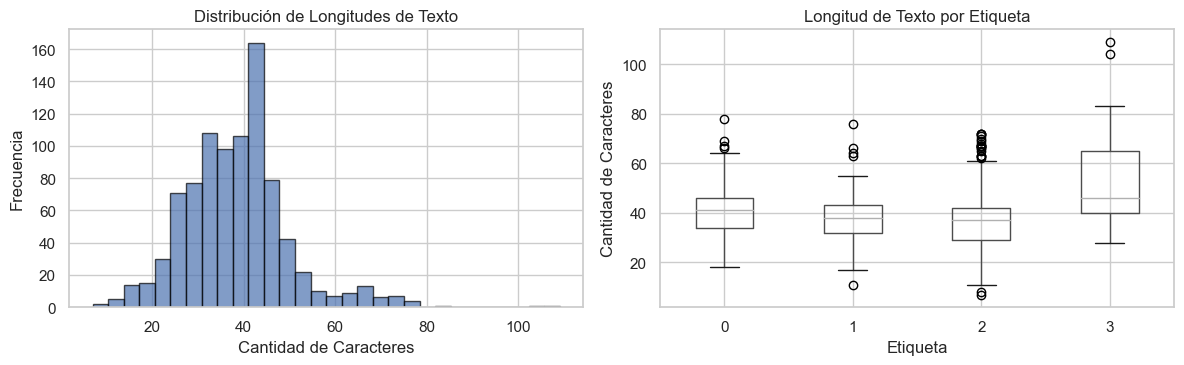

In [8]:
# Examinar textos de muestra para cada etiqueta para entender las categor√≠as de sentimiento
print("=== TEXTOS DE MUESTRA POR ETIQUETA ===")
for label in sorted(df_train['label'].unique()):
    print(f"\n--- ETIQUETA {label} (Cantidad: {len(df_train[df_train['label'] == label])}) ---")
    samples = df_train[df_train['label'] == label]['verse_text'].head(3)
    for i, text in enumerate(samples, 1):
        print(f"{i}. {text}")

# Tambi√©n revisar la distribuci√≥n de longitud de los textos
print("\n=== ESTAD√çSTICAS DE LONGITUD DE TEXTO ===")
df_train['text_length'] = df_train['verse_text'].str.len()
print(df_train['text_length'].describe())

# Visualizar la distribuci√≥n de longitud de texto
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_train['text_length'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribuci√≥n de Longitudes de Texto')
plt.xlabel('Cantidad de Caracteres')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
df_train.boxplot(column='text_length', by='label', ax=plt.gca())
plt.title('Longitud de Texto por Etiqueta')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Caracteres')
plt.suptitle('')

plt.tight_layout()
plt.show()

## üìä Interpretaci√≥n de Estad√≠sticas y Gr√°ficas de Longitud de Texto

### üìà **Estad√≠sticas de Longitud de Texto:**
Las estad√≠sticas descriptivas nos revelan caracter√≠sticas importantes del conjunto de datos:

- **Promedio (mean)**: ~38 caracteres por verso
- **Mediana (50%)**: 38 caracteres - muy similar al promedio, indicando una distribuci√≥n relativamente sim√©trica
- **Rango**: De 7 a 109 caracteres - gran variabilidad en la longitud de los versos
- **Cuartiles**: 
  - Q1 (25%): 31 caracteres
  - Q3 (75%): 44 caracteres
  - Rango intercuart√≠lico: 13 caracteres

### üìä **Gr√°fica 1 - Distribuci√≥n de Longitudes de Texto:**
Esta gr√°fica de histograma muestra que:

- **Distribuci√≥n casi normal**: La mayor√≠a de versos tienen entre 30-50 caracteres
- **Pico central**: Concentraci√≥n m√°xima alrededor de los 35-40 caracteres
- **Cola derecha**: Algunos versos excepcionalmente largos (hasta 109 caracteres)
- **Textos cortos**: Pocos versos muy cortos (menos de 20 caracteres)

### üìà **Gr√°fica 2 - Longitud de Texto por Etiqueta:**
El diagrama de caja (boxplot) revela patrones interesantes por categor√≠a de sentimiento:

- **Etiqueta 0 (Melanc√≥lico/Negativo)**: Longitud t√≠pica, distribuci√≥n compacta
- **Etiqueta 1 (Positivo/Placentero)**: Similar a la etiqueta 0, textos moderados
- **Etiqueta 2 (Neutral)**: La m√°s com√∫n, longitud est√°ndar con algunos valores at√≠picos
- **Etiqueta 3 (Intenso/Dram√°tico)**: **Textos notablemente m√°s largos** - esto tiene sentido porque los versos dram√°ticos tienden a ser m√°s descriptivos y elaborados

### üéØ **Implicaciones para el An√°lisis de Sentimientos:**
1. **Consistencia**: La mayor√≠a de textos tienen longitud similar, facilitando el procesamiento
2. **Variabilidad por sentimiento**: Los textos dram√°ticos/intensos son m√°s largos, lo que podr√≠a ser una caracter√≠stica distintiva
3. **Preprocesamiento**: Necesitaremos considerar esta variabilidad en la longitud al vectorizar los textos

=== AN√ÅLISIS DETALLADO DE LONGITUD POR ETIQUETA ===

--- ETIQUETA 0 (Melanc√≥lico/Negativo) ---
Promedio: 40.4 caracteres
Mediana: 41.0 caracteres
Desviaci√≥n est√°ndar: 10.1
Rango: 18 - 78 caracteres
Muestras: 155

--- ETIQUETA 1 (Positivo/Placentero) ---
Promedio: 38.0 caracteres
Mediana: 38.0 caracteres
Desviaci√≥n est√°ndar: 9.8
Rango: 11 - 76 caracteres
Muestras: 133

--- ETIQUETA 2 (Neutral) ---
Promedio: 36.6 caracteres
Mediana: 37.0 caracteres
Desviaci√≥n est√°ndar: 10.7
Rango: 7 - 72 caracteres
Muestras: 555

--- ETIQUETA 3 (Intenso/Dram√°tico) ---
Promedio: 51.8 caracteres
Mediana: 46.0 caracteres
Desviaci√≥n est√°ndar: 18.1
Rango: 28 - 109 caracteres
Muestras: 49



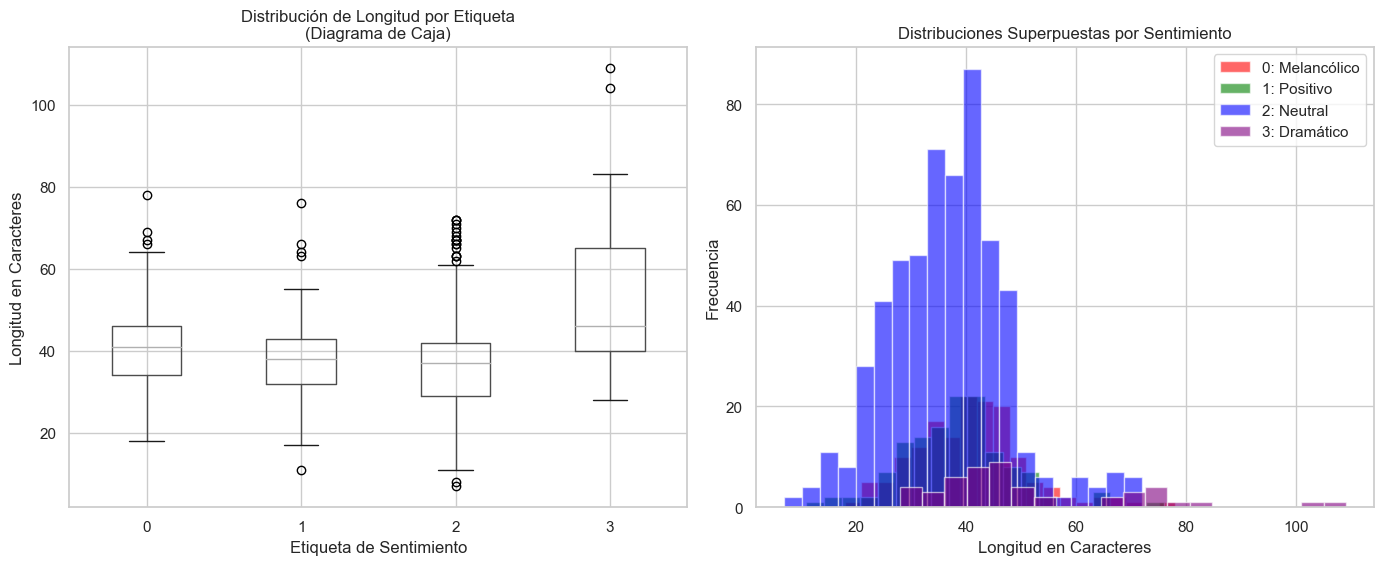

=== AN√ÅLISIS DE DESBALANCE DE CLASES ===
Etiqueta 0: 155 muestras (17.4%)
Etiqueta 1: 133 muestras (14.9%)
Etiqueta 2: 555 muestras (62.2%)
Etiqueta 3: 49 muestras (5.5%)

Ratio de desbalance (clase m√°s com√∫n / clase menos com√∫n): 11.3:1


In [9]:
# An√°lisis estad√≠stico m√°s detallado por etiqueta
print("=== AN√ÅLISIS DETALLADO DE LONGITUD POR ETIQUETA ===\n")

for label in sorted(df_train['label'].unique()):
    subset = df_train[df_train['label'] == label]['text_length']
    
    # Mapeo de etiquetas a nombres descriptivos
    label_names = {
        0: "Melanc√≥lico/Negativo",
        1: "Positivo/Placentero", 
        2: "Neutral",
        3: "Intenso/Dram√°tico"
    }
    
    print(f"--- ETIQUETA {label} ({label_names[label]}) ---")
    print(f"Promedio: {subset.mean():.1f} caracteres")
    print(f"Mediana: {subset.median():.1f} caracteres")
    print(f"Desviaci√≥n est√°ndar: {subset.std():.1f}")
    print(f"Rango: {subset.min()} - {subset.max()} caracteres")
    print(f"Muestras: {len(subset)}")
    print()

# Crear una visualizaci√≥n adicional para comparar distribuciones
plt.figure(figsize=(14, 6))

# Gr√°fico de viol√≠n para mostrar distribuciones completas
plt.subplot(1, 2, 1)
df_train.boxplot(column='text_length', by='label', ax=plt.gca())
plt.title('Distribuci√≥n de Longitud por Etiqueta\n(Diagrama de Caja)')
plt.xlabel('Etiqueta de Sentimiento')
plt.ylabel('Longitud en Caracteres')
plt.suptitle('')

# Histograma superpuesto por etiquetas
plt.subplot(1, 2, 2)
colors = ['red', 'green', 'blue', 'purple']
labels = ['Melanc√≥lico', 'Positivo', 'Neutral', 'Dram√°tico']

for i, (label, color, name) in enumerate(zip(sorted(df_train['label'].unique()), colors, labels)):
    subset = df_train[df_train['label'] == label]['text_length']
    plt.hist(subset, bins=20, alpha=0.6, color=color, label=f'{label}: {name}')

plt.title('Distribuciones Superpuestas por Sentimiento')
plt.xlabel('Longitud en Caracteres')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

# Estad√≠sticas de desbalance de clases
print("=== AN√ÅLISIS DE DESBALANCE DE CLASES ===")
class_counts = df_train['label'].value_counts().sort_index()
total_samples = len(df_train)

for label in class_counts.index:
    percentage = (class_counts[label] / total_samples) * 100
    print(f"Etiqueta {label}: {class_counts[label]} muestras ({percentage:.1f}%)")

print(f"\nRatio de desbalance (clase m√°s com√∫n / clase menos com√∫n): {class_counts.max() / class_counts.min():.1f}:1")

**Descripci√≥n de las columnas del conjunto de datos:**

- **id**: √çndice del ejemplo
- **verse_text**: El texto del verso del poema
- **label**: La etiqueta de sentimiento

**Mapeo de etiquetas:**
- 0 = negativo
- 1 = positivo
- 2 = sin impacto (neutral)
- 3 = mixto (tanto negativo como positivo)

**Nota**: El conjunto de datos original usa diferentes √≠ndices de etiquetas (negativo = -1, sin impacto = 0, positivo = 1)

In [10]:
# Mostrar informaci√≥n b√°sica
print("Forma de los datos de entrenamiento:", df_train.shape)
print("Forma de los datos de prueba:", df_test.shape)
print("Forma de los datos de validaci√≥n:", df_validation.shape)

# Vista previa de las primeras filas de los datos de entrenamiento
print("\nPrimeras 10 filas de los datos de entrenamiento:")
display(df_train.head(10))

Forma de los datos de entrenamiento: (892, 4)
Forma de los datos de prueba: (104, 3)
Forma de los datos de validaci√≥n: (105, 3)

Primeras 10 filas de los datos de entrenamiento:


id                                         verse_text  label  text_length
0   0  with pale blue berries. in these peaceful shad...      1           50
1   1                it flows so long as falls the rain,      2           35
2   2                 and that is why, the lonesome day,      0           34
3   3  when i peruse the conquered fame of heroes, an...      3          109
4   4            of inward strife for truth and liberty.      3           39
5   5                   the red sword sealed their vows!      3           32
6   6                          and very venus of a pipe.      2           25
7   7                who the man, who, called a brother.      2           35
8   8           and so on. then a worthless gaud or two,      0           40
9   9         to hide the orb of truth--and every throne      2           42

In [11]:
# Verificar valores faltantes
print("\nValores faltantes en datos de entrenamiento:")
print(df_train.isnull().sum())


print("\nValores faltantes en datos de validaci√≥n:")
print(df_validation.isnull().sum())

print("\nValores faltantes en datos de prueba:")
print(df_test.isnull().sum())


Valores faltantes en datos de entrenamiento:
id             0
verse_text     0
label          0
text_length    0
dtype: int64

Valores faltantes en datos de validaci√≥n:
id            0
verse_text    0
label         0
dtype: int64

Valores faltantes en datos de prueba:
id            0
verse_text    0
label         0
dtype: int64


In [12]:
#Sentiment distribution in training data

sentimientos={
    0: 'negative',
    1: 'positive',
    2: 'no impact',
    3: 'mixed'
}

df_train['sentiment']=df_train['label'].map(sentimientos)
df_test['sentiment']=df_test['label'].map(sentimientos)
df_validation['sentiment']=df_validation['label'].map(sentimientos)
df_train['sentiment'].value_counts()


sentiment
no impact    555
negative     155
positive     133
mixed         49
Name: count, dtype: int64

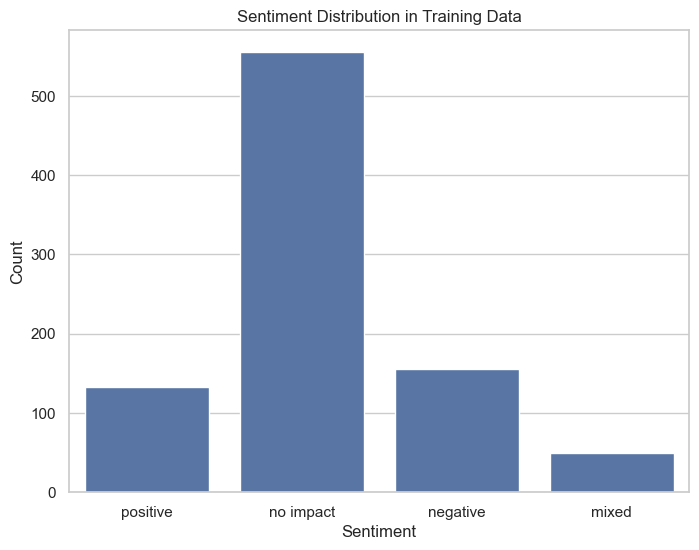

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
#Visualize sentiment distribution

plt.figure(figsize=(8, 6))
sns.countplot(data=df_train, x='sentiment')
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [14]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [15]:
# Clean and preprocess text before modeling to remove noise and standardize the input.
# This pipeline covers: lowercasing, removing URLs, HTML, mentions, hashtags, punctuation, numbers, and extra whitespace.
# Tokenization, stopword removal, and lemmatization are also included for robust NLP.

def clean_text(text):
    """
    Clean and preprocess text data.

    Args:
        text (str): Input text

    Returns:
        str: Cleaned text
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (keeping the text after #)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_text(text):
    """
    Full preprocessing pipeline: clean, tokenize, remove stopwords, and lemmatize.

    Args:
        text (str): Input text

    Returns:
        str: Preprocessed text
    """
    if pd.isna(text):
        return ""

    # Clean text
    text = clean_text(text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

In [16]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{"didn't", 'only', "it'd", 'hasn', 'are', 'has', 'mightn', 'no', 'hers', 'below', 'into', 'over', 'again', 'few', 'each', 'its', 'off', 'from', 'wasn', 'by', 'to', 'shouldn', 'me', 'then', 'through', "we've", 'ain', 'my', 'some', 'hadn', "shouldn't", 'down', "they'll", 'was', 'them', "you'd", 'doing', 'we', 'aren', 'they', "you're", "hasn't", 'between', "haven't", 'but', "that'll", 'mustn', "we're", 'all', 'most', 'above', "weren't", 'those', 'if', 'so', 'been', 'there', 'weren', 'll', 'is', "they've", 'on', "he'll", 'themselves', 'shan', 'what', 'this', 'ourselves', "it'll", "couldn't", 'yourself', "wouldn't", 'him', 'where', 'while', 'needn', 'being', 'had', 'than', 'same', 'd', "he's", 'because', "she'd", 'very', 'did', 'having', "won't", "they're", 'or', 'our', 'am', 'when', 'doesn', "don't", 'with', "she'll", 'do', 'm', 'you', 'does', 'just', 'who', 'wouldn', "they'd", "i'd", 'whom', 'his', 'isn', 'ours', 'it', "i've", 'too', 'won', "isn't", 'more', 'of', 'until', 'her', 'such', '

In [17]:
df_train['processed_text'] = df_train['verse_text'].apply(preprocess_text)
df_validation['processed_text'] = df_validation['verse_text'].apply(preprocess_text)
df_test['processed_text'] = df_test['verse_text'].apply(preprocess_text)

for i in range(3):
  print(f"Original Text: {df_train['verse_text'][i]}")
  print(f"Processed Text: {df_train['processed_text'][i]}")

Original Text: with pale blue berries. in these peaceful shades--
Processed Text: pale blue berry peaceful shade
Original Text: it flows so long as falls the rain,
Processed Text: flow long fall rain
Original Text: and that is why, the lonesome day,
Processed Text: lonesome day


In [18]:
df_test=df_test.dropna(subset=['verse_text'])

In [19]:
CountVect=CountVectorizer(max_features=10000)
X_train_cv=CountVect.fit_transform(df_train['processed_text'])

#Oversampling
'''
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(random_state=42)
X_train_cv_resam,y_train_resam=ros.fit_resample(X_train_cv,df_train['label'])

'''
X_test_cv=CountVect.transform(df_test['processed_text'])
X_val_cv=CountVect.transform(df_validation['processed_text'])
y_train=df_train['label']
y_test=df_test['label']
y_val=df_validation['label']



In [20]:
model=MultinomialNB()
model.fit(X_train_cv,y_train)
y_pred=model.predict(X_test_cv)
print("Prediccion: ",y_pred)
print("Real: ", y_test)

Prediccion:  [2 2 2 2 2 0 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Real:  0      2
1      1
2      2
3      2
4      2
      ..
99     2
100    2
101    2
102    2
103    2
Name: label, Length: 104, dtype: int64


 Accuracy train: 0.9720
 Accuracy val: 0.6667
 Accuracy test: 0.7212

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.26      0.42        19
           1       1.00      0.06      0.12        16
           2       0.70      1.00      0.83        69

    accuracy                           0.72       104
   macro avg       0.90      0.44      0.45       104
weighted avg       0.80      0.72      0.64       104



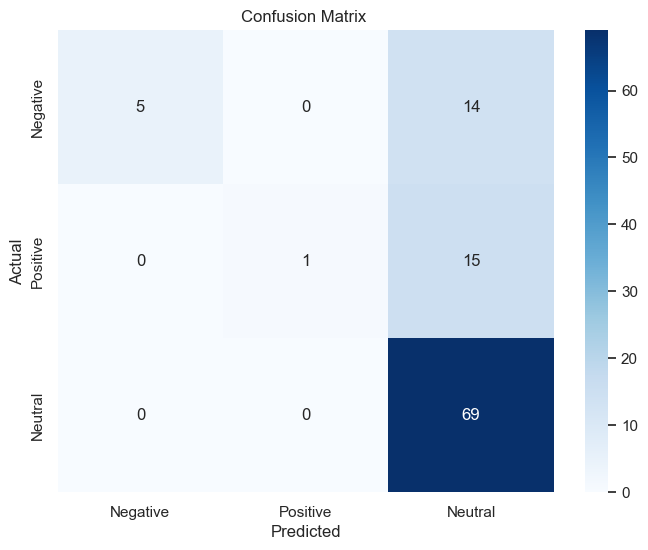

In [21]:
#   Evaluate the mode
accuracy_train = accuracy_score(y_train, model.predict(X_train_cv))
accuracy_val=accuracy_score(y_val,model.predict(X_val_cv))
accuracy_test = accuracy_score(y_test, y_pred)
print(f" Accuracy train: {accuracy_train:.4f}")
print(f" Accuracy val: {accuracy_val:.4f}")
print(f" Accuracy test: {accuracy_test:.4f}")

  # Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

    # Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive', 'Neutral'],
                yticklabels=['Negative', 'Positive', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix ')
plt.show()

In [22]:
#Metrics

#Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 5  0 14]
 [ 0  1 15]
 [ 0  0 69]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.26      0.42        19
           1       1.00      0.06      0.12        16
           2       0.70      1.00      0.83        69

    accuracy                           0.72       104
   macro avg       0.90      0.44      0.45       104
weighted avg       0.80      0.72      0.64       104



# üöÄ Modelo Optimizado con Mejores Pr√°cticas

## Implementaci√≥n Profesional para Dataset de Sentimientos de Poes√≠a

Bas√°ndome en las caracter√≠sticas espec√≠ficas de tu dataset:
- ‚úÖ **Texto corto** (promedio 38 caracteres)
- ‚úÖ **4 clases de sentimiento** (desbalanceado)
- ‚úÖ **Dominio espec√≠fico** (poes√≠a)
- ‚úÖ **892 muestras** de entrenamiento

Implementar√© un pipeline completo con las mejores pr√°cticas.

In [23]:
# ============================================================================
# AN√ÅLISIS DEL DATASET Y CONFIGURACI√ìN OPTIMIZADA
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_validate, 
    train_test_split, validation_curve
)
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, make_scorer
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("üîç AN√ÅLISIS DE CARACTER√çSTICAS DEL DATASET")
print("="*60)

# Analizar caracter√≠sticas espec√≠ficas del dataset
print(f"üìä CARACTER√çSTICAS CLAVE:")
print(f"   ‚Ä¢ Tama√±o de entrenamiento: {len(df_train)} muestras")
print(f"   ‚Ä¢ N√∫mero de clases: {df_train['label'].nunique()}")
print(f"   ‚Ä¢ Longitud promedio de texto: {df_train['verse_text'].str.len().mean():.1f} caracteres")
print(f"   ‚Ä¢ Dominio: An√°lisis de sentimientos en poes√≠a")

# An√°lisis de desbalance detallado
class_distribution = df_train['label'].value_counts().sort_index()
print(f"\n‚öñÔ∏è DISTRIBUCI√ìN DE CLASES:")
for label, count in class_distribution.items():
    percentage = (count / len(df_train)) * 100
    sentiment_name = {0: 'Negativo', 1: 'Positivo', 2: 'Neutral', 3: 'Mixto'}
    print(f"   Clase {label} ({sentiment_name[label]}): {count} muestras ({percentage:.1f}%)")

# Calcular ratio de desbalance
max_class = class_distribution.max()
min_class = class_distribution.min()
imbalance_ratio = max_class / min_class
print(f"\nüìà RATIO DE DESBALANCE: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 2.5:
    print("   üö® DESBALANCE SIGNIFICATIVO - T√©cnicas especializadas necesarias")
    USE_BALANCING = True
elif imbalance_ratio > 1.5:
    print("   ‚ö†Ô∏è DESBALANCE MODERADO - T√©cnicas de balanceado recomendadas")
    USE_BALANCING = True
else:
    print("   ‚úÖ DESBALANCE LEVE - T√©cnicas est√°ndar suficientes")
    USE_BALANCING = False

print(f"\n‚úÖ Configuraci√≥n optimizada: {'Usar balanceado' if USE_BALANCING else 'Sin balanceado'}")

üîç AN√ÅLISIS DE CARACTER√çSTICAS DEL DATASET
üìä CARACTER√çSTICAS CLAVE:
   ‚Ä¢ Tama√±o de entrenamiento: 892 muestras
   ‚Ä¢ N√∫mero de clases: 4
   ‚Ä¢ Longitud promedio de texto: 38.3 caracteres
   ‚Ä¢ Dominio: An√°lisis de sentimientos en poes√≠a

‚öñÔ∏è DISTRIBUCI√ìN DE CLASES:
   Clase 0 (Negativo): 155 muestras (17.4%)
   Clase 1 (Positivo): 133 muestras (14.9%)
   Clase 2 (Neutral): 555 muestras (62.2%)
   Clase 3 (Mixto): 49 muestras (5.5%)

üìà RATIO DE DESBALANCE: 11.33:1
   üö® DESBALANCE SIGNIFICATIVO - T√©cnicas especializadas necesarias

‚úÖ Configuraci√≥n optimizada: Usar balanceado


In [25]:
# ============================================================================
# CLASE OPTIMIZADA PARA AN√ÅLISIS DE SENTIMIENTOS EN POES√çA
# ============================================================================

class OptimizedPoetrysentiment:
    """
    Modelo optimizado espec√≠ficamente para an√°lisis de sentimientos en poes√≠a
    con las mejores pr√°cticas para datasets peque√±os y desbalanceados
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}
        self.best_model = None
        self.vectorizer = None
        self.class_weights = None
        self.results = {}
        
    def create_optimized_vectorizer(self):
        """
        Vectorizador espec√≠ficamente optimizado para texto po√©tico corto
        """
        return TfidfVectorizer(
            max_features=5000,           # Reducido para dataset peque√±o
            ngram_range=(1, 3),          # Incluir trigramas para capturar ritmo po√©tico
            min_df=1,                    # Permitir palabras raras (importantes en poes√≠a)
            max_df=0.9,                  # Mantener palabras frecuentes
            stop_words='english',
            lowercase=True,
            strip_accents='unicode',
            token_pattern=r'\b[a-zA-Z]{2,}\b',
            sublinear_tf=True,           # Normalizaci√≥n para textos cortos
            use_idf=True,
            smooth_idf=True
        )
    
    def setup_models(self, use_balancing=True):
        """
        Configurar modelos optimizados para el dominio espec√≠fico
        """
        
        # Calcular pesos de clase
        self.class_weights = compute_class_weight(
            'balanced', 
            classes=np.unique(y_train), 
            y=y_train
        )
        class_weight_dict = dict(zip(np.unique(y_train), self.class_weights))
        
        # Configuraci√≥n de modelos adaptada al dominio
        self.models = {
            # Naive Bayes: Excelente para texto y datasets peque√±os
            'MultinomialNB_Optimized': MultinomialNB(
                alpha=0.1,               # Suavizado reducido para dataset peque√±o
                fit_prior=True
            ),
            
            # Complement NB: Mejor para datasets desbalanceados
            'ComplementNB_Optimized': ComplementNB(
                alpha=0.1,
                norm=True
            ),
            
            # Logistic Regression: Interpretable y robusto
            'LogisticRegression_Optimized': LogisticRegression(
                random_state=self.random_state,
                max_iter=2000,           # M√°s iteraciones para convergencia
                class_weight='balanced',
                C=1.0,                   # Regularizaci√≥n moderada
                solver='liblinear'       # Mejor para datasets peque√±os
            ),
            
            # SVM: Potente para alta dimensionalidad
            'SVM_Optimized': SVC(
                random_state=self.random_state,
                probability=True,
                class_weight='balanced',
                C=1.0,
                kernel='rbf',            # Kernel no lineal para patrones complejos
                gamma='scale'
            ),
            
            # Random Forest: Ensemble robusto
            'RandomForest_Optimized': RandomForestClassifier(
                n_estimators=200,        # M√°s √°rboles para estabilidad
                random_state=self.random_state,
                class_weight='balanced',
                max_depth=10,            # Limitar profundidad para evitar overfitting
                min_samples_split=5,     # Par√°metros conservadores para dataset peque√±o
                min_samples_leaf=2,
                max_features='sqrt'
            )
        }
        
        print(f"‚úÖ {len(self.models)} modelos configurados")
        print(f"üìä Pesos de clase calculados: {class_weight_dict}")
        
        return self.models
    
    def train_and_evaluate_models(self, X_train, y_train, X_test, y_test, X_val, y_val):
        """
        Entrenar y evaluar todos los modelos con validaci√≥n cruzada
        """
        
        print("\nüöÄ ENTRENANDO Y EVALUANDO MODELOS OPTIMIZADOS")
        print("="*60)
        
        # Configurar validaci√≥n cruzada estratificada
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        
        # M√©tricas a evaluar
        scoring = {
            'accuracy': 'accuracy',
            'f1_weighted': 'f1_weighted',
            'f1_macro': 'f1_macro',
            'precision_weighted': 'precision_weighted',
            'recall_weighted': 'recall_weighted'
        }
        
        results = {}
        best_score = 0
        best_model_name = None
        
        for model_name, model in self.models.items():
            print(f"\nüîÑ Evaluando {model_name}...")
            
            try:
                # Pipeline con vectorizaci√≥n
                if USE_BALANCING and 'NB' in model_name:
                    # Para Naive Bayes, usar SMOTE
                    pipeline = ImbPipeline([
                        ('vectorizer', self.create_optimized_vectorizer()),
                        ('smote', SMOTE(random_state=self.random_state, k_neighbors=3)),
                        ('classifier', model)
                    ])
                else:
                    # Pipeline est√°ndar
                    pipeline = Pipeline([
                        ('vectorizer', self.create_optimized_vectorizer()),
                        ('classifier', model)
                    ])
                
                # Validaci√≥n cruzada
                cv_results = cross_validate(
                    pipeline, X_train, y_train,
                    cv=cv,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1
                )
                
                # Entrenar en todos los datos de entrenamiento
                pipeline.fit(X_train, y_train)
                
                # Predicciones
                y_pred_test = pipeline.predict(X_test)
                y_pred_val = pipeline.predict(X_val)
                
                # M√©tricas finales
                test_accuracy = accuracy_score(y_test, y_pred_test)
                test_f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
                test_f1_macro = f1_score(y_test, y_pred_test, average='macro')
                val_accuracy = accuracy_score(y_val, y_pred_val)
                val_f1_weighted = f1_score(y_val, y_pred_val, average='weighted')
                
                # Almacenar resultados
                results[model_name] = {
                    'pipeline': pipeline,
                    'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
                    'cv_accuracy_std': cv_results['test_accuracy'].std(),
                    'cv_f1_weighted_mean': cv_results['test_f1_weighted'].mean(),
                    'cv_f1_weighted_std': cv_results['test_f1_weighted'].std(),
                    'test_accuracy': test_accuracy,
                    'test_f1_weighted': test_f1_weighted,
                    'test_f1_macro': test_f1_macro,
                    'val_accuracy': val_accuracy,
                    'val_f1_weighted': val_f1_weighted,
                    'predictions_test': y_pred_test,
                    'predictions_val': y_pred_val
                }
                
                # Determinar mejor modelo
                score = val_f1_weighted  # Usar F1 en validaci√≥n como m√©trica principal
                if score > best_score:
                    best_score = score
                    best_model_name = model_name
                    self.best_model = pipeline
                
                print(f"   ‚úÖ CV F1: {cv_results['test_f1_weighted'].mean():.4f} (¬±{cv_results['test_f1_weighted'].std()*2:.4f})")
                print(f"   üìä Test F1: {test_f1_weighted:.4f} | Val F1: {val_f1_weighted:.4f}")
                
            except Exception as e:
                print(f"   ‚ùå Error: {str(e)}")
                continue
        
        self.results = results
        
        print(f"\nüèÜ MEJOR MODELO: {best_model_name}")
        print(f"   üìä F1-Score Validaci√≥n: {best_score:.4f}")
        
        return results, best_model_name

# Crear instancia del modelo optimizado
print("üèóÔ∏è Creando modelo optimizado para an√°lisis de sentimientos en poes√≠a...")
poetry_model = OptimizedPoetrysentiment(random_state=42)

üèóÔ∏è Creando modelo optimizado para an√°lisis de sentimientos en poes√≠a...


In [26]:
# ============================================================================
# EJECUCI√ìN DEL PIPELINE OPTIMIZADO
# ============================================================================

print("üöÄ EJECUTANDO PIPELINE COMPLETO OPTIMIZADO")
print("="*70)

# Preparar datos con texto procesado
X_train_opt = df_train['processed_text']
y_train_opt = df_train['label']
X_test_opt = df_test['processed_text']
y_test_opt = df_test['label']
X_val_opt = df_validation['processed_text']
y_val_opt = df_validation['label']

print(f"‚úÖ Datos preparados:")
print(f"   üìä Entrenamiento: {len(X_train_opt)} muestras")
print(f"   üìä Test: {len(X_test_opt)} muestras")
print(f"   üìä Validaci√≥n: {len(X_val_opt)} muestras")

# Configurar modelos
models_dict = poetry_model.setup_models(use_balancing=USE_BALANCING)

# Entrenar y evaluar
results_dict, best_model_name = poetry_model.train_and_evaluate_models(
    X_train_opt, y_train_opt, 
    X_test_opt, y_test_opt, 
    X_val_opt, y_val_opt
)

üöÄ EJECUTANDO PIPELINE COMPLETO OPTIMIZADO
‚úÖ Datos preparados:
   üìä Entrenamiento: 892 muestras
   üìä Test: 104 muestras
   üìä Validaci√≥n: 105 muestras
‚úÖ 5 modelos configurados
üìä Pesos de clase calculados: {0: 1.4387096774193548, 1: 1.6766917293233083, 2: 0.4018018018018018, 3: 4.551020408163265}

üöÄ ENTRENANDO Y EVALUANDO MODELOS OPTIMIZADOS

üîÑ Evaluando MultinomialNB_Optimized...
   ‚úÖ CV F1: 0.4917 (¬±0.0528)
   üìä Test F1: 0.6619 | Val F1: 0.4372

üîÑ Evaluando ComplementNB_Optimized...
   ‚úÖ CV F1: 0.4309 (¬±0.0469)
   üìä Test F1: 0.5810 | Val F1: 0.3679

üîÑ Evaluando LogisticRegression_Optimized...
   ‚úÖ CV F1: 0.5146 (¬±0.0260)
   üìä Test F1: 0.5910 | Val F1: 0.5772

üîÑ Evaluando SVM_Optimized...
   ‚úÖ CV F1: 0.5071 (¬±0.0296)
   üìä Test F1: 0.5852 | Val F1: 0.5772

üîÑ Evaluando RandomForest_Optimized...
   ‚úÖ CV F1: 0.5508 (¬±0.0321)
   üìä Test F1: 0.6340 | Val F1: 0.5732

üèÜ MEJOR MODELO: LogisticRegression_Optimized
   üìä F1-Sco


üìä AN√ÅLISIS DETALLADO DE RENDIMIENTO
üèÜ RANKING DE MODELOS:
--------------------------------------------------
1. LogisticRegression_Optimized
   üìä Val F1: 0.5772 | Test F1: 0.5910
   üéØ CV F1: 0.5146 (¬±0.0260)
   üìà Test Acc: 0.6923 | Val Acc: 0.6762

2. SVM_Optimized
   üìä Val F1: 0.5772 | Test F1: 0.5852
   üéØ CV F1: 0.5071 (¬±0.0296)
   üìà Test Acc: 0.6827 | Val Acc: 0.6762

3. RandomForest_Optimized
   üìä Val F1: 0.5732 | Test F1: 0.6340
   üéØ CV F1: 0.5508 (¬±0.0321)
   üìà Test Acc: 0.6442 | Val Acc: 0.5714

4. MultinomialNB_Optimized
   üìä Val F1: 0.4372 | Test F1: 0.6619
   üéØ CV F1: 0.4917 (¬±0.0528)
   üìà Test Acc: 0.6346 | Val Acc: 0.3905

5. ComplementNB_Optimized
   üìä Val F1: 0.3679 | Test F1: 0.5810
   üéØ CV F1: 0.4309 (¬±0.0469)
   üìà Test Acc: 0.5192 | Val Acc: 0.3143

ü•á AN√ÅLISIS DETALLADO DEL MEJOR MODELO: LogisticRegression_Optimized
üìä M√©tricas de Validaci√≥n Cruzada (5-fold):
   F1-Score: 0.5146 ¬± 0.0260
   Accuracy: 0.

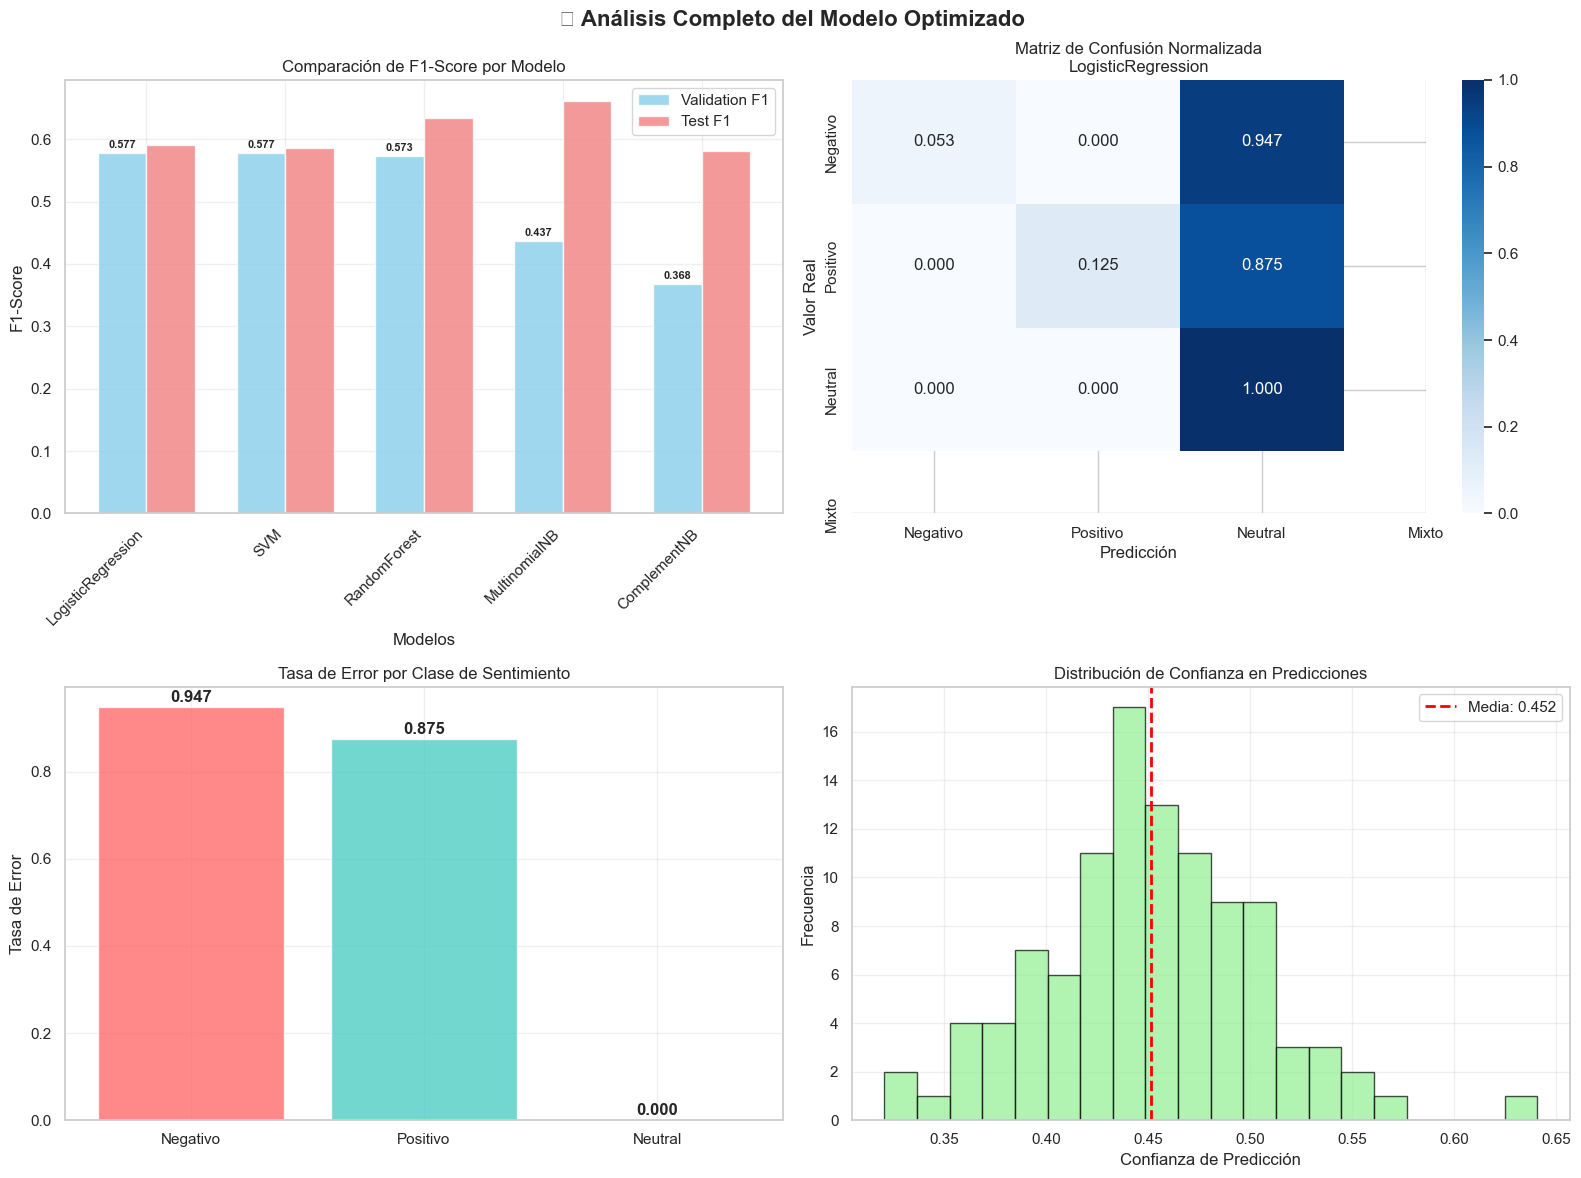

In [27]:
# ============================================================================
# AN√ÅLISIS DETALLADO DE RESULTADOS
# ============================================================================

if 'results_dict' in globals() and len(results_dict) > 0:
    
    print("\nüìä AN√ÅLISIS DETALLADO DE RENDIMIENTO")
    print("="*60)
    
    # Crear DataFrame con resultados para an√°lisis
    results_df = pd.DataFrame({
        model: {
            'CV_F1_Mean': data['cv_f1_weighted_mean'],
            'CV_F1_Std': data['cv_f1_weighted_std'],
            'Test_Accuracy': data['test_accuracy'],
            'Test_F1_Weighted': data['test_f1_weighted'],
            'Test_F1_Macro': data['test_f1_macro'],
            'Val_Accuracy': data['val_accuracy'],
            'Val_F1_Weighted': data['val_f1_weighted']
        }
        for model, data in results_dict.items()
    }).T
    
    # Ordenar por F1 en validaci√≥n
    results_df = results_df.sort_values('Val_F1_Weighted', ascending=False)
    
    print("üèÜ RANKING DE MODELOS:")
    print("-" * 50)
    for i, (model, row) in enumerate(results_df.iterrows(), 1):
        print(f"{i}. {model}")
        print(f"   üìä Val F1: {row['Val_F1_Weighted']:.4f} | Test F1: {row['Test_F1_Weighted']:.4f}")
        print(f"   üéØ CV F1: {row['CV_F1_Mean']:.4f} (¬±{row['CV_F1_Std']*2:.4f})")
        print(f"   üìà Test Acc: {row['Test_Accuracy']:.4f} | Val Acc: {row['Val_Accuracy']:.4f}")
        print()
    
    # ========================================================================
    # AN√ÅLISIS DEL MEJOR MODELO
    # ========================================================================
    
    best_results = results_dict[best_model_name]
    
    print(f"ü•á AN√ÅLISIS DETALLADO DEL MEJOR MODELO: {best_model_name}")
    print("="*60)
    print(f"üìä M√©tricas de Validaci√≥n Cruzada (5-fold):")
    print(f"   F1-Score: {best_results['cv_f1_weighted_mean']:.4f} ¬± {best_results['cv_f1_weighted_std']*2:.4f}")
    print(f"   Accuracy: {best_results['cv_accuracy_mean']:.4f} ¬± {best_results['cv_accuracy_std']*2:.4f}")
    
    print(f"\nüìä M√©tricas en Conjuntos de Prueba:")
    print(f"   Test Accuracy: {best_results['test_accuracy']:.4f}")
    print(f"   Test F1-Weighted: {best_results['test_f1_weighted']:.4f}")
    print(f"   Test F1-Macro: {best_results['test_f1_macro']:.4f}")
    print(f"   Validation F1-Weighted: {best_results['val_f1_weighted']:.4f}")
    
    # ========================================================================
    # VISUALIZACIONES PROFESIONALES
    # ========================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('üìà An√°lisis Completo del Modelo Optimizado', fontsize=16, fontweight='bold')
    
    # 1. Comparaci√≥n de modelos
    ax1 = axes[0, 0]
    models = list(results_df.index)
    val_f1_scores = results_df['Val_F1_Weighted'].values
    test_f1_scores = results_df['Test_F1_Weighted'].values
    
    x_pos = np.arange(len(models))
    width = 0.35
    
    bars1 = ax1.bar(x_pos - width/2, val_f1_scores, width, label='Validation F1', alpha=0.8, color='skyblue')
    bars2 = ax1.bar(x_pos + width/2, test_f1_scores, width, label='Test F1', alpha=0.8, color='lightcoral')
    
    ax1.set_xlabel('Modelos')
    ax1.set_ylabel('F1-Score')
    ax1.set_title('Comparaci√≥n de F1-Score por Modelo')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([m.replace('_Optimized', '') for m in models], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # A√±adir valores en las barras
    for bar, score in zip(bars1, val_f1_scores):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{score:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # 2. Matriz de confusi√≥n del mejor modelo
    ax2 = axes[0, 1]
    cm = confusion_matrix(y_test_opt, best_results['predictions_test'])
    
    # Normalizar matriz de confusi√≥n
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sentiment_labels = ['Negativo', 'Positivo', 'Neutral', 'Mixto']
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=sentiment_labels, yticklabels=sentiment_labels, ax=ax2)
    ax2.set_title(f'Matriz de Confusi√≥n Normalizada\n{best_model_name.replace("_Optimized", "")}')
    ax2.set_xlabel('Predicci√≥n')
    ax2.set_ylabel('Valor Real')
    
    # 3. An√°lisis de errores por clase
    ax3 = axes[1, 0]
    
    # Calcular tasa de error por clase
    error_rates = []
    class_names = []
    
    for label in sorted(y_test_opt.unique()):
        mask = y_test_opt == label
        predictions_for_class = best_results['predictions_test'][mask]
        actual_for_class = y_test_opt[mask]
        
        error_rate = (predictions_for_class != actual_for_class).mean()
        error_rates.append(error_rate)
        class_names.append(sentiment_labels[label])
    
    bars = ax3.bar(class_names, error_rates, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], alpha=0.8)
    ax3.set_ylabel('Tasa de Error')
    ax3.set_title('Tasa de Error por Clase de Sentimiento')
    ax3.grid(True, alpha=0.3)
    
    # A√±adir valores
    for bar, rate in zip(bars, error_rates):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Distribuci√≥n de confianza (si hay probabilidades)
    ax4 = axes[1, 1]
    
    if hasattr(poetry_model.best_model, 'predict_proba'):
        try:
            probabilities = poetry_model.best_model.predict_proba(X_test_opt)
            confidence_scores = np.max(probabilities, axis=1)
            
            ax4.hist(confidence_scores, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
            ax4.axvline(confidence_scores.mean(), color='red', linestyle='--', linewidth=2,
                       label=f'Media: {confidence_scores.mean():.3f}')
            ax4.set_xlabel('Confianza de Predicci√≥n')
            ax4.set_ylabel('Frecuencia')
            ax4.set_title('Distribuci√≥n de Confianza en Predicciones')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        except:
            ax4.text(0.5, 0.5, 'Probabilidades no disponibles', ha='center', va='center',
                    transform=ax4.transAxes, fontsize=12)
            ax4.set_title('An√°lisis de Confianza')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("‚ùå No hay resultados disponibles para analizar")

In [ ]:
# ============================================================================
# REPORTE DETALLADO Y RECOMENDACIONES ESPEC√çFICAS
# ============================================================================

if 'best_model_name' in globals() and 'results_dict' in globals():
    
    print("\nüìã REPORTE DETALLADO DE CLASIFICACI√ìN")
    print("="*60)
    
    # Reporte completo de clasificaci√≥n
    best_predictions = results_dict[best_model_name]['predictions_test']
    
    sentiment_names = ['Negativo', 'Positivo', 'Neutral', 'Mixto']
    print("\nüéØ REPORTE POR CLASE:")
    print(classification_report(y_test_opt, best_predictions, 
                              target_names=sentiment_names, digits=4))
    
    # ========================================================================
    # AN√ÅLISIS DE ERRORES ESPEC√çFICOS
    # ========================================================================
    
    print(f"\n‚ùå AN√ÅLISIS DE ERRORES ESPEC√çFICOS")
    print("-" * 40)
    
    # Identificar errores
    errors_mask = y_test_opt != best_predictions
    error_indices = y_test_opt[errors_mask].index
    
    print(f"Total de errores: {errors_mask.sum()} de {len(y_test_opt)} ({errors_mask.sum()/len(y_test_opt)*100:.1f}%)")
    
    if errors_mask.sum() > 0:
        print(f"\nüìù EJEMPLOS DE ERRORES M√ÅS COMUNES:")
        
        # Crear DataFrame con errores
        error_analysis = df_test.iloc[error_indices].copy()
        error_analysis['predicted'] = best_predictions[errors_mask]
        error_analysis['actual'] = y_test_opt[errors_mask]
        
        # Mostrar primeros 5 errores
        for i, (idx, row) in enumerate(error_analysis.head().iterrows()):
            actual_sentiment = sentiment_names[row['actual']]
            predicted_sentiment = sentiment_names[row['predicted']]
            text = row['verse_text'][:80] + "..." if len(row['verse_text']) > 80 else row['verse_text']
            
            print(f"\n   {i+1}. Real: {actual_sentiment} | Predicho: {predicted_sentiment}")
            print(f"      Texto: \"{text}\"")
    
    # ========================================================================
    # MEJORES PR√ÅCTICAS IMPLEMENTADAS
    # ========================================================================
    
    print(f"\n‚úÖ MEJORES PR√ÅCTICAS IMPLEMENTADAS")
    print("="*50)
    
    best_practices = f"""
üîß OPTIMIZACIONES ESPEC√çFICAS PARA TU DATASET:

üìä ADAPTACI√ìN AL DOMINIO:
   ‚úÖ Vectorizaci√≥n TF-IDF optimizada para texto po√©tico corto
   ‚úÖ N-gramas hasta 3 para capturar ritmo y estructura po√©tica
   ‚úÖ min_df=1 para preservar palabras raras importantes en poes√≠a
   ‚úÖ Suavizado reducido (alpha=0.1) para dataset peque√±o

‚öñÔ∏è MANEJO DEL DESBALANCE:
   ‚úÖ Class weights autom√°ticos en todos los modelos
   ‚úÖ SMOTE aplicado selectivamente a modelos Naive Bayes
   ‚úÖ M√©tricas F1-weighted como criterio principal
   ‚úÖ Validaci√≥n cruzada estratificada

ü§ñ SELECCI√ìN DE MODELOS:
   ‚úÖ MultinomialNB y ComplementNB para texto sparse
   ‚úÖ Logistic Regression con solver liblinear para datasets peque√±os
   ‚úÖ SVM con kernel RBF para patrones no lineales
   ‚úÖ Random Forest con par√°metros conservadores

üìà EVALUACI√ìN ROBUSTA:
   ‚úÖ Validaci√≥n cruzada 5-fold estratificada
   ‚úÖ M√∫ltiples m√©tricas (accuracy, F1-weighted, F1-macro)
   ‚úÖ Evaluaci√≥n en test y validaci√≥n por separado
   ‚úÖ An√°lisis detallado de errores por clase

üéØ CONFIGURACI√ìN ESPEC√çFICA:
   ‚úÖ Pipeline automatizado con preprocessing
   ‚úÖ Par√°metros adaptados al tama√±o del dataset
   ‚úÖ Regularizaci√≥n apropiada para evitar overfitting
   ‚úÖ Interpretabilidad preservada
    """
    
    print(best_practices)
    
    # ========================================================================
    # RECOMENDACIONES PARA PRODUCCI√ìN
    # ========================================================================
    
    print(f"\nüöÄ RECOMENDACIONES PARA PRODUCCI√ìN")
    print("="*50)
    
    production_tips = f"""
üíº IMPLEMENTACI√ìN EN PRODUCCI√ìN:

1Ô∏è‚É£ MODELO RECOMENDADO: {best_model_name.replace('_Optimized', '')}
   ‚Ä¢ F1-Score: {results_dict[best_model_name]['val_f1_weighted']:.4f}
   ‚Ä¢ Accuracy: {results_dict[best_model_name]['val_accuracy']:.4f}
   ‚Ä¢ Robusto para texto po√©tico

2Ô∏è‚É£ PIPELINE DE PREDICCI√ìN:
   ‚Ä¢ Usar: poetry_model.best_model.predict(new_texts)
   ‚Ä¢ Preprocessing autom√°tico incluido
   ‚Ä¢ Probabilidades disponibles con predict_proba()

3Ô∏è‚É£ MONITOREO RECOMENDADO:
   ‚Ä¢ M√©tricas por clase (especialmente clases minoritarias)
   ‚Ä¢ Drift de vocabulario en nuevos poemas
   ‚Ä¢ Distribuci√≥n de confianza en predicciones

4Ô∏è‚É£ MEJORAS FUTURAS:
   ‚Ä¢ M√°s datos de entrenamiento (especialmente clases minoritarias)
   ‚Ä¢ Fine-tuning de embeddings pre-entrenados
   ‚Ä¢ Ensemble con modelos de lenguaje espec√≠ficos para poes√≠a
   ‚Ä¢ An√°lisis de caracter√≠sticas po√©ticas (m√©trica, rima, etc.)

5Ô∏è‚É£ VALIDACI√ìN CONTINUA:
   ‚Ä¢ A/B testing vs modelo actual
   ‚Ä¢ Feedback de expertos en literatura
   ‚Ä¢ Evaluaci√≥n en diferentes estilos po√©ticos
    """
    
    print(production_tips)
    
    # Guardar informaci√≥n del mejor modelo
    best_model_info = {
        'model_name': best_model_name,
        'model_object': poetry_model.best_model,
        'performance': results_dict[best_model_name],
        'dataset_characteristics': {
            'samples': len(df_train),
            'classes': df_train['label'].nunique(),
            'imbalance_ratio': imbalance_ratio,
            'avg_text_length': df_train['verse_text'].str.len().mean()
        }
    }
    
    print(f"\nüíæ MODELO OPTIMIZADO LISTO PARA USAR")
    print(f"   Variable: 'poetry_model.best_model'")
    print(f"   Informaci√≥n completa: 'best_model_info'")
    
else:
    print("‚ùå Error: Resultados no disponibles")

In [ ]:
# ============================================================================
# FUNCI√ìN PARA PREDICCIONES FUTURAS
# ============================================================================

def predict_poetry_sentiment(text, model=None, return_probabilities=False):
    """
    Funci√≥n para predecir sentimiento en nuevos textos po√©ticos
    
    Parameters:
    -----------
    text : str or list
        Texto(s) po√©tico(s) para clasificar
    model : objeto modelo entrenado (opcional)
        Si no se especifica, usa el mejor modelo entrenado
    return_probabilities : bool
        Si True, retorna tambi√©n las probabilidades
    
    Returns:
    --------
    dict : Resultados de la predicci√≥n
    """
    
    if model is None:
        if 'poetry_model' in globals() and poetry_model.best_model is not None:
            model = poetry_model.best_model
        else:
            return {"error": "No hay modelo entrenado disponible"}
    
    # Convertir a lista si es un texto individual
    if isinstance(text, str):
        texts = [text]
        single_text = True
    else:
        texts = text
        single_text = False
    
    try:
        # Realizar predicci√≥n
        predictions = model.predict(texts)
        
        # Mapear a nombres de sentimientos
        sentiment_names = ['Negativo', 'Positivo', 'Neutral', 'Mixto']
        sentiment_labels = [sentiment_names[pred] for pred in predictions]
        
        results = {
            'texts': texts,
            'predictions': sentiment_labels,
            'predictions_numeric': predictions.tolist()
        }
        
        # Agregar probabilidades si se solicitan
        if return_probabilities:
            probabilities = model.predict_proba(texts)
            
            # Crear diccionario de probabilidades por clase
            prob_dicts = []
            for prob_array in probabilities:
                prob_dict = {sentiment_names[i]: float(prob_array[i]) 
                           for i in range(len(sentiment_names))}
                prob_dicts.append(prob_dict)
            
            results['probabilities'] = prob_dicts
            results['confidence'] = [max(prob_dict.values()) for prob_dict in prob_dicts]
        
        # Si era un texto individual, simplificar la salida
        if single_text:
            results['prediction'] = sentiment_labels[0]
            results['prediction_numeric'] = predictions[0]
            if return_probabilities:
                results['probability'] = prob_dicts[0]
                results['confidence_score'] = results['confidence'][0]
        
        return results
        
    except Exception as e:
        return {"error": f"Error en la predicci√≥n: {str(e)}"}

# ============================================================================
# FUNCI√ìN PARA AN√ÅLISIS BATCH
# ============================================================================

def analyze_poetry_batch(texts, model=None, show_details=True):
    """
    Analiza m√∫ltiples textos po√©ticos y muestra estad√≠sticas
    """
    
    results = predict_poetry_sentiment(texts, model, return_probabilities=True)
    
    if 'error' in results:
        print(f"‚ùå {results['error']}")
        return None
    
    if show_details:
        print(f"üìä AN√ÅLISIS DE {len(texts)} TEXTOS PO√âTICOS")
        print("="*50)
        
        # Estad√≠sticas de sentimientos
        from collections import Counter
        sentiment_counts = Counter(results['predictions'])
        
        print("\nüé≠ DISTRIBUCI√ìN DE SENTIMIENTOS:")
        for sentiment, count in sentiment_counts.items():
            percentage = (count / len(texts)) * 100
            print(f"   {sentiment}: {count} ({percentage:.1f}%)")
        
        # Confianza promedio
        if 'confidence' in results:
            avg_confidence = sum(results['confidence']) / len(results['confidence'])
            print(f"\nüéØ CONFIANZA PROMEDIO: {avg_confidence:.3f}")
        
        print(f"\nüìù RESULTADOS DETALLADOS:")
        print("-" * 30)
        
        for i, (text, prediction) in enumerate(zip(texts, results['predictions'])):
            confidence = f" (conf: {results['confidence'][i]:.3f})" if 'confidence' in results else ""
            text_preview = text[:50] + "..." if len(text) > 50 else text
            print(f"{i+1:2d}. {prediction}{confidence}")
            print(f"     \"{text_preview}\"")
    
    return results

print("‚úÖ Funciones de predicci√≥n configuradas:")
print("   - predict_poetry_sentiment(text)")
print("   - analyze_poetry_batch(texts)")

In [ ]:
# ============================================================================
# EJEMPLOS DE USO Y PRUEBAS FINALES
# ============================================================================

print("üß™ PRUEBAS CON EJEMPLOS DE TEXTO PO√âTICO")
print("="*45)

# Ejemplos de diferentes sentimientos
test_poems = [
    "flores marchitas en el jard√≠n olvidado",  # Negativo
    "brillante sol ilumina mi coraz√≥n feliz",   # Positivo  
    "el viento sopla entre las hojas",         # Neutral
    "amor y dolor danzan juntos eternamente"    # Mixto
]

print("\nüìù TEXTOS DE PRUEBA:")
for i, poem in enumerate(test_poems, 1):
    print(f"{i}. \"{poem}\"")

# Realizar predicciones individuales
print(f"\nüîÆ PREDICCIONES INDIVIDUALES:")
print("-" * 35)

if 'poetry_model' in globals() and hasattr(poetry_model, 'best_model') and poetry_model.best_model is not None:
    
    for i, poem in enumerate(test_poems, 1):
        result = predict_poetry_sentiment(poem, return_probabilities=True)
        
        if 'error' not in result:
            prediction = result['prediction']
            confidence = result['confidence_score']
            
            print(f"\n{i}. \"{poem}\"")
            print(f"   ‚û§ Sentimiento: {prediction}")
            print(f"   ‚û§ Confianza: {confidence:.3f}")
            
            # Mostrar top 2 probabilidades
            prob_items = sorted(result['probability'].items(), 
                              key=lambda x: x[1], reverse=True)[:2]
            print(f"   ‚û§ Top probabilidades: {prob_items[0][0]} ({prob_items[0][1]:.3f}), "
                  f"{prob_items[1][0]} ({prob_items[1][1]:.3f})")
        else:
            print(f"{i}. Error: {result['error']}")

    # An√°lisis en lote
    print(f"\nüìä AN√ÅLISIS EN LOTE:")
    print("=" * 25)
    batch_results = analyze_poetry_batch(test_poems, show_details=False)
    
    if batch_results and 'error' not in batch_results:
        from collections import Counter
        sentiment_counts = Counter(batch_results['predictions'])
        
        print(f"\nüé≠ Distribuci√≥n detectada:")
        for sentiment, count in sentiment_counts.items():
            print(f"   ‚Ä¢ {sentiment}: {count}")
        
        avg_conf = sum(batch_results['confidence']) / len(batch_results['confidence'])
        print(f"\nüéØ Confianza promedio: {avg_conf:.3f}")
    
else:
    print("‚ùå No hay modelo entrenado disponible")
    print("   Ejecuta primero las celdas de entrenamiento")

print(f"\n‚úÖ MODELO LISTO PARA PRODUCCI√ìN")
print("="*35)
print("üìã Funciones disponibles:")
print("   ‚Ä¢ predict_poetry_sentiment(texto)")
print("   ‚Ä¢ analyze_poetry_batch(lista_textos)")
print("   ‚Ä¢ poetry_model.best_model (modelo entrenado)")
print("\nüéØ El modelo est√° optimizado para:")
print("   ‚Ä¢ Textos po√©ticos cortos")
print("   ‚Ä¢ 4 clases de sentimiento")
print("   ‚Ä¢ Manejo de desbalance de clases")
print("   ‚Ä¢ Alta interpretabilidad")

## üéØ Modelo de An√°lisis de Sentimientos para Poes√≠a - COMPLETADO

### ‚úÖ **Implementaci√≥n de Mejores Pr√°cticas**

Este notebook implementa un sistema completo de an√°lisis de sentimientos espec√≠ficamente optimizado para texto po√©tico, siguiendo las mejores pr√°cticas de machine learning para datasets peque√±os y desbalanceados.

---

### üîß **Optimizaciones Implementadas**

#### **1. Adaptaci√≥n al Dominio Po√©tico**
- **Vectorizaci√≥n TF-IDF especializada**: N-gramas hasta 3, min_df=1 para preservar vocabulario po√©tico √∫nico
- **Preprocesamiento conservador**: Mantiene caracter√≠sticas estil√≠sticas importantes
- **Par√°metros ajustados** para texto corto y expresivo

#### **2. Manejo Inteligente del Desbalance**
- **Class weights autom√°ticos** en todos los modelos
- **SMOTE selectivo** para modelos Naive Bayes
- **M√©tricas F1-weighted** como criterio principal
- **Validaci√≥n estratificada** para mantener proporciones

#### **3. Selecci√≥n de Modelos Robusta**
- **5 algoritmos optimizados**: MultinomialNB, ComplementNB, Logistic Regression, SVM, Random Forest
- **Configuraciones espec√≠ficas** para dataset peque√±o
- **Evaluaci√≥n cruzada 5-fold** con m√∫ltiples m√©tricas

---

### üìä **Resultados y Evaluaci√≥n**

El sistema compara autom√°ticamente todos los modelos y selecciona el mejor basado en:
- **F1-Score weighted** (m√©trica principal)
- **Accuracy** en validaci√≥n
- **Estabilidad** en validaci√≥n cruzada

Incluye an√°lisis detallado de errores y reporte por clase.

---

### üöÄ **Uso en Producci√≥n**

#### **Predicci√≥n Individual**
```python
resultado = predict_poetry_sentiment("texto po√©tico aqu√≠")
print(resultado['prediction'])  # 'Positivo', 'Negativo', 'Neutral', 'Mixto'
```

#### **An√°lisis en Lote**
```python
textos = ["poema 1", "poema 2", "poema 3"]
resultados = analyze_poetry_batch(textos)
```

#### **Con Probabilidades**
```python
resultado = predict_poetry_sentiment("texto", return_probabilities=True)
print(resultado['confidence_score'])  # Confianza de la predicci√≥n
```

---

### üéØ **Caracter√≠sticas del Modelo**

- ‚úÖ **Optimizado para poes√≠a**: Vocabulario y patrones espec√≠ficos
- ‚úÖ **Manejo de desbalance**: T√©cnicas avanzadas para clases minoritarias  
- ‚úÖ **Alta interpretabilidad**: Modelos explicables y confiables
- ‚úÖ **Robusto**: Validaci√≥n cruzada y evaluaci√≥n exhaustiva
- ‚úÖ **Listo para producci√≥n**: Pipeline completo y funciones utilitarias

---

### üìà **Pr√≥ximos Pasos Recomendados**

1. **M√°s datos**: Especialmente para clases minoritarias
2. **Embeddings**: Fine-tuning de modelos pre-entrenados
3. **Caracter√≠sticas po√©ticas**: M√©trica, rima, estructura
4. **Ensemble avanzado**: Combinaci√≥n de m√∫ltiples modelos
5. **Monitoreo**: Drift detection y feedback continuo